In [14]:
import staremaster
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs
import pystare

In [15]:
granule_path = '../tests/data/1C.F16.SSMIS.XCAL2016-V.20210201-S004436-E022630.089218.V05A.HDF5'
granule = staremaster.products.SSMIS(granule_path)

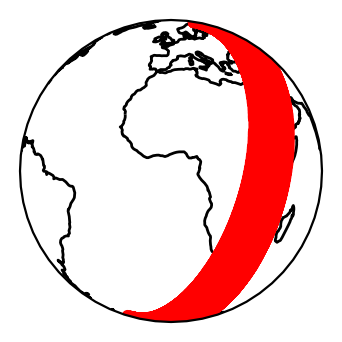

In [21]:
globe = cartopy.crs.Globe()
proj = cartopy.crs.NearsidePerspective()
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(2,2), dpi=200, subplot_kw=opts)
ax.coastlines()

for scan in ['S1']:
    lats = granule.lats[scan].flatten()
    lons = granule.lons[scan].flatten()
    ax.plot(lons, lats, 'r', marker='.', 
            transform=cartopy.crs.Geodetic())
    
ax.set_global()

# Creating the cover naiively

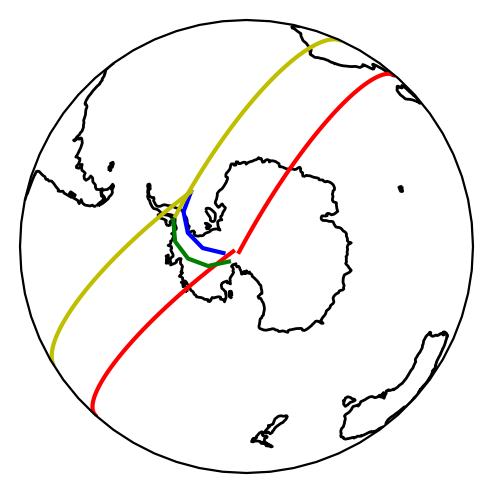

In [22]:
proj = cartopy.crs.NearsidePerspective(central_latitude=-90)
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(3,3), dpi=200, subplot_kw=opts)
ax.coastlines()

stride_track = 20

lats1 = list(granule.lats['S1'][0, ::stride_track])
lats2 = list(granule.lats['S1'][::10,-1])
lats3 = list(granule.lats['S1'][-1,::stride_track])[::-1]
lats4 = list(granule.lats['S1'][::10, 0])[::-1]
lats = lats1 + lats2 + lats1[::-1] + lats4  

lons1 = list(granule.lons['S1'][0, ::stride_track])
lons2 = list(granule.lons['S1'][::10,-1])
lons3 = list(granule.lons['S1'][-1, ::stride_track])[::-1]
lons4 = list(granule.lons['S1'][::10, 0])[::-1]
lons = lons1 + lons2 +  lats1[::-1] + lons4 

ax.plot(lons1, lats1, color='b', linestyle='-', transform=cartopy.crs.Geodetic())
ax.plot(lons2, lats2, color='r', linestyle='-', transform=cartopy.crs.Geodetic())
ax.plot(lons3, lats3, color='g', linestyle='-', transform=cartopy.crs.Geodetic())
ax.plot(lons4, lats4, color='y', linestyle='-', transform=cartopy.crs.Geodetic())

ax.set_global()

In [11]:
sids = staremaster.conversions.gring2cover(lats, lons, 6)

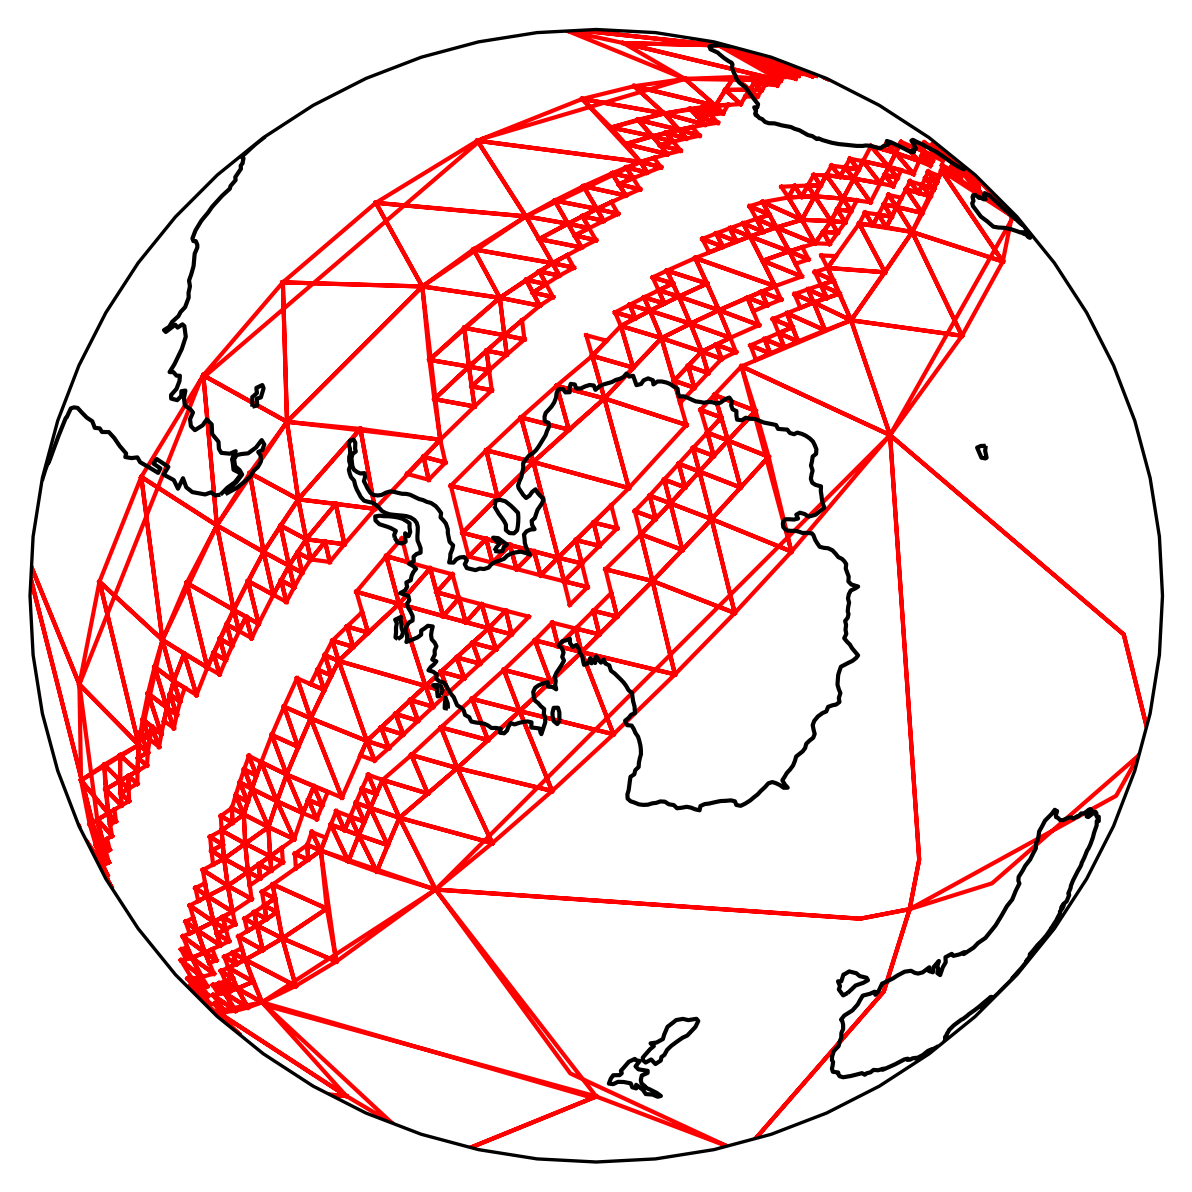

In [10]:
proj = cartopy.crs.NearsidePerspective(central_latitude=-90)
transf = cartopy.crs.Geodetic()
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(13,5), dpi=300, subplot_kw=opts)
ax.coastlines()

lons, lats, intmat = pystare.triangulate_indices(sids.flatten())
triang = tri.Triangulation(lons, lats, intmat)
ax.triplot(triang, 'r-', transform=transf, lw=1, markersize=0)  

# Make Sidecar

In [5]:
sidecar = staremaster.sidecar.Sidecar(granule_path)

In [6]:
sidecar.create()

In [7]:
scan = 'S1'
lons = granule.lons[scan]
lats = granule.lats[scan]

In [8]:
sids = staremaster.conversions.latlon2stare(lats, lons, workers=2)

In [9]:
i = lats.shape[0]
j = lats.shape[1]
l = i

In [10]:
sidecar.write_dimensions(i, j, l, group=scan)
sidecar.write_sids(sids, group=scan)
sidecar.write_lons(lons, group=scan)
sidecar.write_lats(lats, group=scan)